In [1095]:
#imports
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [1096]:
train = pd.read_csv("/content/train (1).csv") #THIS IS CSV, reads faster
train.head(2)

,transDate,creditCardNum,business,category,amount,firstName,lastName,gender,street,city,...,zip,latitude,longitude,cityPop,job,dateOfBirth,transNum,merchLatitude,merchLongitude,isFraud
0,2019-01-01 4:28,4.120000e+15,fraud_Welch Inc,misc_net,4.10,Melinda,Gutierrez,F,1497 West Gateway,Eureka,...,61530,40.7152,-89.2706,6713,Archivist,1945-08-19,3fc1791ff1db94ce9540262d7eb973e4,40.020043,-89.693412,0
1,2019-01-01 4:28,3.610000e+13,fraud_Auer-West,shopping_net,2.67,Christopher,Horn,M,956 Sanchez Highway,Mallie,...,41836,37.2692,-82.9161,798,Facilities manager,2026-06-26,edbf65b8606b53fc48168c2daa5933e5,37.622362,-82.676007,0


In [1097]:
train = train.dropna() # drop missing values
train = train.drop(['street','transNum'],axis=1) # drop variables not being used
train.shape

(181822, 19)

In [1098]:
# USE FOR CSV FORMAT
train[['transDate', 'time']] = train['transDate'].str.split(' ', expand=True)
# Convert the string date column to datetime
train['transDate'] = pd.to_datetime(train['transDate'])
train['dateOfBirth'] = pd.to_datetime(train['dateOfBirth'])

# Convert the datetime to serial date
train['transDate'] = train['transDate'].apply(lambda x: x.toordinal()) # is this okay?? might screw up model cause not same numbers anymore
train['dateOfBirth'] = train['dateOfBirth'].apply(lambda x: x.toordinal())

# Function to convert time to minutes past midnight
def time_to_minutes(time_str):
    hour, minute = map(int, time_str.split(':'))
    return hour * 60 + minute

# Convert time to minutes past midnight
train['time'] = train['time'].apply(time_to_minutes) # also not same numbers from before...


In [1099]:
print(train.dtypes)

transDate           int64
creditCardNum     float64
business           object
category           object
amount            float64
firstName          object
lastName           object
gender             object
city               object
state              object
zip                 int64
latitude          float64
longitude         float64
cityPop             int64
job                object
dateOfBirth         int64
merchLatitude     float64
merchLongitude    float64
isFraud             int64
time                int64
dtype: object


In [1100]:
train.head(1)

,transDate,creditCardNum,business,category,amount,firstName,lastName,gender,city,state,zip,latitude,longitude,cityPop,job,dateOfBirth,merchLatitude,merchLongitude,isFraud,time
0,737060,4.120000e+15,fraud_Welch Inc,misc_net,4.1,Melinda,Gutierrez,F,Eureka,IL,61530,40.7152,-89.2706,6713,Archivist,710262,40.020043,-89.693412,0,268


In [1101]:
# # DON'T USE THIS IF USING CSV FORMAT
# from datetime import datetime

# # Separate date and time
# train['Time'] = train['transDate'].dt.hour * 3600 + train['transDate'].dt.minute * 60 + train['transDate'].dt.second
# train['transDate'] = train['transDate'].dt.date

# # Base date in Excel (December 30, 1899)
# base_date = datetime(1899, 12, 30)

# # Function to convert datetime to serial date
# def datetime_to_serial_date(datetime_value):
#     # Convert date object to datetime object by combining with a time component
#     datetime_value = datetime.combine(datetime_value, datetime.min.time())
#     delta = datetime_value - base_date
#     return delta.days + delta.seconds / (24 * 3600)

# # Convert the datetime column to serial date format
# train['transDate'] = train['transDate'].apply(datetime_to_serial_date)
# train['dateOfBirth'] = train['dateOfBirth'].apply(datetime_to_serial_date)
# train.head(1)

In [1102]:
# Assuming your DataFrame is called train
# Combine 'first name' and 'last name' to create a new column 'full name'
train['fullName'] = train['firstName'] + ', ' + train['lastName']

# Group by 'full name' and calculate the fraud rate
fraud_rate_df = train.groupby('fullName')['isFraud'].mean().reset_index()

# Rename the 'isFraud' column to 'fraud_rate'
fraud_rate_df.rename(columns={'isFraud': 'fraud_rate_name'}, inplace=True)

# Merge the fraud_rate_df back into the original DataFrame based on 'full name'
train = pd.merge(train, fraud_rate_df, on='fullName', how='left')

# Drop the 'full name' column if you no longer need it

# Print the updated DataFrame

In [1103]:
# Assuming train is your DataFrame
train['numCreditCards'] = train.groupby('fullName')['creditCardNum'].transform('nunique')

# Displaying the DataFrame with the new column

In [1104]:
# Assuming your DataFrame is called train

# List of categorical variables
categorical_cols = ['business', 'category', 'city', 'state', 'gender', 'zip', 'job']

# Loop through each categorical variable
for col in categorical_cols:
    # Calculate the fraud rate for each combination of the current categorical variable and 'isFraud'
    fraud_rate_df = train.groupby(col)['isFraud'].mean().reset_index()

    # Rename the 'isFraud' column to 'fraud_rate'
    fraud_rate_df.rename(columns={'isFraud': f'fraud_rate_{col}'}, inplace=True)

    # Merge the fraud_rate_df back into the original DataFrame based on the current categorical variable
    train = pd.merge(train, fraud_rate_df, on=col, how='left', suffixes=('', '_y'))

    # Drop duplicate columns if they exist
    train = train.loc[:,~train.columns.duplicated()]

# Print the updated DataFrame

In [1105]:
train.head(2)

,transDate,creditCardNum,business,category,amount,firstName,lastName,gender,city,state,...,fullName,fraud_rate_name,numCreditCards,fraud_rate_business,fraud_rate_category,fraud_rate_city,fraud_rate_state,fraud_rate_gender,fraud_rate_zip,fraud_rate_job
0,737060,4.120000e+15,fraud_Welch Inc,misc_net,4.10,Melinda,Gutierrez,F,Eureka,IL,...,"Melinda, Gutierrez",0.0,1,0.022472,0.018064,0.0,0.008063,0.006757,0.0,0.000000
1,737060,3.610000e+13,fraud_Auer-West,shopping_net,2.67,Christopher,Horn,M,Mallie,KY,...,"Christopher, Horn",0.0,1,0.008299,0.023101,0.0,0.010800,0.008066,0.0,0.012844


In [1106]:
# Drop columns with '_x' or '_y' suffixes
train = train.filter(regex='^(?!.*(_x|_y)$)')

In [1107]:
# missing_values = train.isnull().sum()
# print(missing_values)

# Training

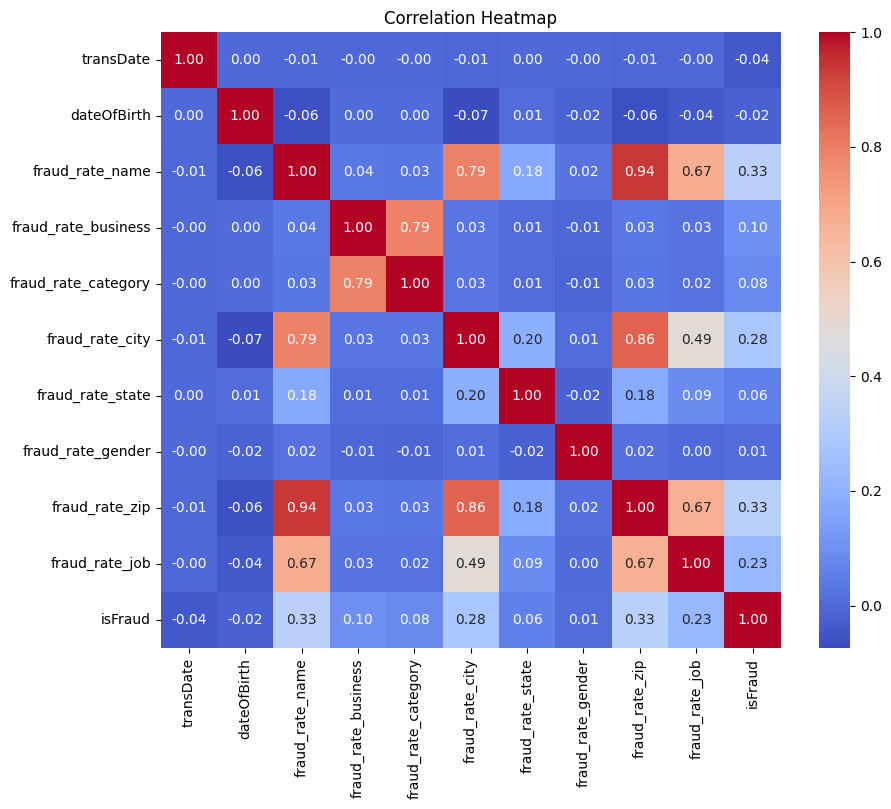

In [1108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called train

# Select columns for correlation analysis
columns_for_correlation = ['transDate', 'dateOfBirth', 'fraud_rate_name', 'fraud_rate_business', 'fraud_rate_category', 'fraud_rate_city', 'fraud_rate_state', 'fraud_rate_gender', 'fraud_rate_zip', 'fraud_rate_job', 'isFraud']

# Subset the DataFrame with selected columns
correlation_df = train[columns_for_correlation]

# Calculate correlation matrix
correlation_matrix = correlation_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap')
plt.show()


In [1109]:
# nan_counts = train.isna().sum()
# nan_counts
# columns_for_correlation = [ 'fraud_rate_name', 'fraud_rate_business', 'fraud_rate_category', 'fraud_rate_city', 'fraud_rate_zip', 'fraud_rate_job', 'isFraud']



In [1110]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Separate features (X) and target variable (y)
X = correlation_df.drop(columns=['isFraud'])
y = correlation_df['isFraud']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Initialize Logistic Regression model
model = LogisticRegression(class_weight='balanced')

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.5699711260827719

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.72     36099
           1       0.01      0.65      0.02       266

    accuracy                           0.57     36365
   macro avg       0.50      0.61      0.37     36365
weighted avg       0.99      0.57      0.72     36365



In [1111]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'max_depth': [3, 5, 7],              # Maximum depth of the trees
#     'learning_rate': [0.01, 0.1, 0.3],   # Learning rate
#     'n_estimators': [100, 200, 300],     # Number of trees in the ensemble
#     'gamma': [0, 0.1, 0.2],              # Minimum loss reduction required to make a further partition on a leaf node of the tree
#     'subsample': [0.6, 0.8, 1.0],        # Subsample ratio of the training instances
#     'colsample_bytree': [0.6, 0.8, 1.0]  # Subsample ratio of columns when constructing each tree
# }

# # Initialize XGBoost classifier
# model_xgb = xgb.XGBClassifier(random_state=42)

# # Initialize GridSearchCV with the XGBoost classifier and parameter grid
# grid_search = GridSearchCV(model_xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # Perform grid search to find the best hyperparameters
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Evaluate the model with best hyperparameters on the test set
# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test)

# # Print classification report
# print("\nClassification Report with Best Hyperparameters:")
# print(classification_report(y_test, y_pred_best))


In [1112]:
correlation_df.dtypes

transDate                int64
dateOfBirth              int64
fraud_rate_name        float64
fraud_rate_business    float64
fraud_rate_category    float64
fraud_rate_city        float64
fraud_rate_state       float64
fraud_rate_gender      float64
fraud_rate_zip         float64
fraud_rate_job         float64
isFraud                  int64
dtype: object

In [1113]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = correlation_df.drop(columns=['isFraud'])
y = correlation_df['isFraud']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Initialize XGBoost classifier
model_xgb = xgb.XGBClassifier(colsample_bytree= 1.0, gamma= 0, learning_rate= 0.3, max_depth= 5, n_estimators= 300, subsample= 1.0)

# Train the model
model_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate model performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy_xgb)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


Accuracy: 0.9989550391860306

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36066
           1       0.97      0.90      0.93       299

    accuracy                           1.00     36365
   macro avg       0.99      0.95      0.97     36365
weighted avg       1.00      1.00      1.00     36365



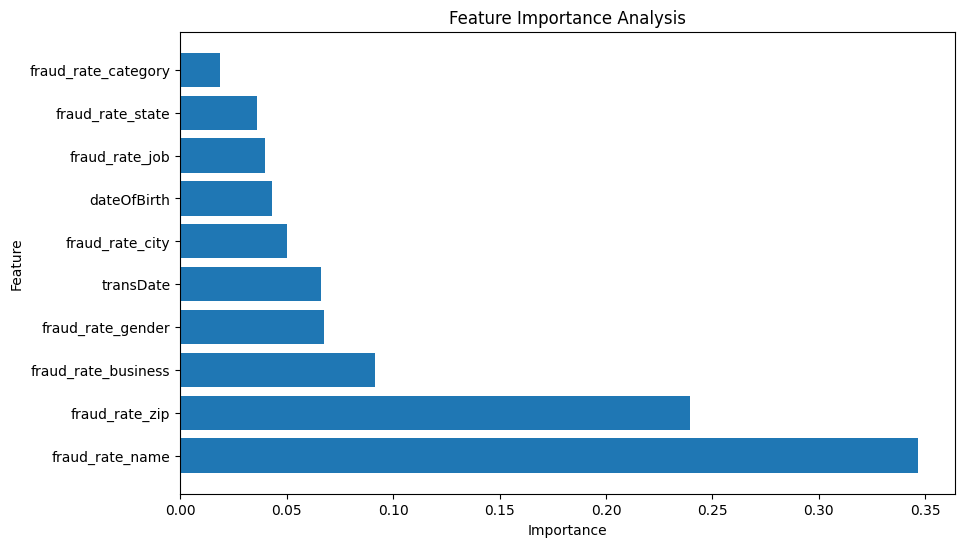

In [1114]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Initialize XGBoost classifier with the best hyperparameters
best_model = xgb.XGBClassifier(colsample_bytree= 1.0, gamma= 0, learning_rate= 0.3, max_depth= 5, n_estimators= 300, subsample= 1.0, random_state=24)

# Train the model on the entire training data
best_model.fit(X_train, y_train)

# Get feature importances from the trained model
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature names and importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Analysis')
plt.show()


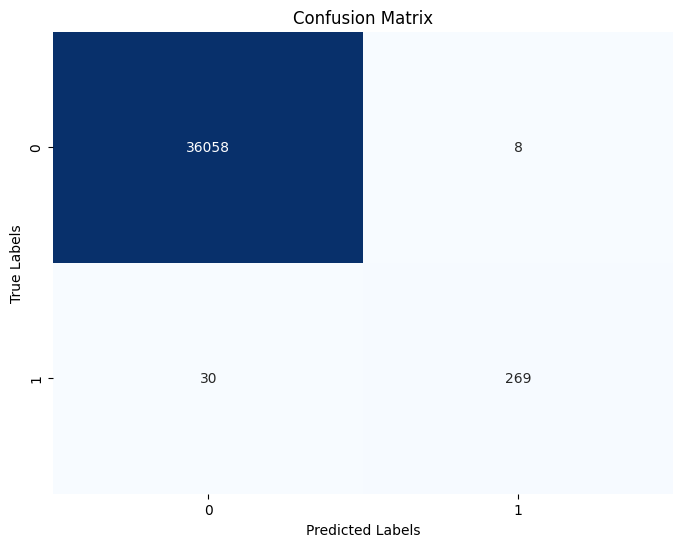

In [1115]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


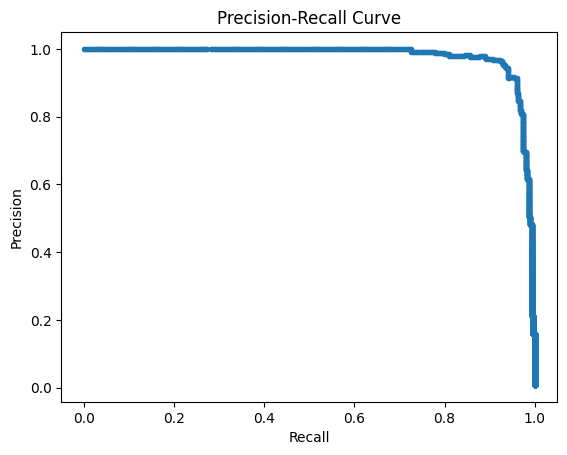

In [1116]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, model_xgb.predict_proba(X_test)[:, 1])

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()



In [1117]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import train_test_split

# # Separate features (X) and target variable (y)
# X = correlation_df.drop(columns=['isFraud'])
# y = correlation_df['isFraud']

# # Split the data into training and testing sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize Decision Tree classifier
# model_dt = DecisionTreeClassifier()

# # Train the model
# model_dt.fit(X_train, y_train)

# # Predict on the test set
# y_pred_dt = model_dt.predict(X_test)

# # Evaluate model performance
# accuracy_dt = accuracy_score(y_test, y_pred_dt)
# print("Accuracy:", accuracy_dt)

# # Classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_dt))


In [1118]:
# from imblearn.ensemble import BalancedBaggingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import classification_report
# from sklearn.model_selection import train_test_split

# # Separate features (X) and target variable (y)
# X = correlation_df.drop(columns=['isFraud'])
# y = correlation_df['isFraud']

# # Split the data into training and testing sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize Decision Tree classifier (base estimator)
# base_estimator = DecisionTreeClassifier()

# # Initialize BalancedBaggingClassifier with Decision Tree base estimator
# model_balanced_bagging = BalancedBaggingClassifier(base_estimator=base_estimator, random_state=42)

# # Train the model
# model_balanced_bagging.fit(X_train, y_train)

# # Predict on the test set
# y_pred_balanced_bagging = model_balanced_bagging.predict(X_test)

# # Print classification report
# print("Classification Report:")
# print(classification_report(y_test, y_pred_balanced_bagging))


Prediction

In [1119]:
test = pd.read_csv("/content/test3.csv") #THIS IS CSV, reads faster
test.head()


,transDate,creditCardNum,business,category,amount,firstName,lastName,gender,street,city,...,fraud_rate_business,fraud_rate_category,fraud_rate_city,fraud_rate_state,fraud_rate_zip,fraud_rate_job,Unnamed: 29,Unnamed: 30,Unnamed: 31,fullName
0,2020-07-03,3.540000e+15,"fraud_Schmeler, Bashirian and Price",shopping_net,1115.94,Stephanie,Freeman,F,44613 James Turnpike,Rice,...,0.037543,0.023101,NaN,0.002005,NaN,NaN,NaN,NaN,NaN,StephanieFreeman
1,2020-09-04,4.420000e+15,fraud_Kozey-Boehm,shopping_net,942.70,Renee,Jones,F,914 Nancy Square,Birmingham,...,0.031008,0.023101,0.0,0.001952,NaN,NaN,NaN,NaN,NaN,ReneeJones
2,2020-09-04,4.420000e+15,fraud_Miller-Hauck,grocery_pos,336.46,Renee,Jones,F,914 Nancy Square,Birmingham,...,0.015060,0.017673,0.0,0.001952,NaN,NaN,NaN,NaN,NaN,ReneeJones
3,2020-09-04,4.420000e+15,fraud_Predovic Inc,shopping_net,1016.98,Renee,Jones,F,914 Nancy Square,Birmingham,...,0.014388,0.023101,0.0,0.001952,NaN,NaN,NaN,NaN,NaN,ReneeJones
4,2020-09-04,3.550000e+15,"fraud_Heller, Gutmann and Zieme",grocery_pos,332.59,Morgan,James,F,742 Sellers Ferry,Lexington,...,0.013228,0.017673,NaN,0.010800,NaN,NaN,NaN,NaN,NaN,MorganJames


In [1120]:
test = test.drop(['street'],axis=1) # drop variables not being used
test.shape

(2251, 32)

In [1121]:
# USE FOR CSV FORMAT
split_columns = test['transDate'].str.split(' ', expand=True)
if len(split_columns.columns) != 3:
    print("Error: Expected 3 columns after split, but found", len(split_columns.columns))
else:
    test[['transDate', 'time', 'ampm']] = split_columns


Error: Expected 3 columns after split, but found 1


In [1122]:
# # USE FOR CSV FORMAT
# test[['transDate', 'time', 'ampm']] = test['transDate'].str.split(' ', expand=True)

# # Convert the string date column to datetime
# test['transDate'] = pd.to_datetime(test['transDate'])
test['dateOfBirth'] = pd.to_datetime(test['dateOfBirth'])

# # Convert the datetime to serial date
# test['transDate'] = test['transDate'].apply(lambda x: x.toordinal())

# # Function to convert time to minutes past midnight
# def time_to_minutes(hour_str, minute_str, ampm):
#     # Convert hour and minute to integers
#     hour = int(hour_str)
#     minute = int(minute_str)
#     # Adjust hour for PM time
#     if ampm == 'PM' and hour < 12:  # If hour is less than 12, add 12 for PM time
#         hour += 12
#     # Adjust hour for AM time if it's 12 AM (midnight)
#     if ampm == 'AM' and hour == 12:
#         hour = 0
#     # Convert time to minutes past midnight
#     minutes_past_midnight = hour * 60 + minute
#     return minutes_past_midnight

# # Convert time to minutes past midnight
# test['time'] = test.apply(lambda row: time_to_minutes(row['time'], row['ampm']), axis=1)

# # Drop the intermediate columns 'time' and 'ampm'
# test.drop(columns=[ 'ampm'], inplace=True)


In [1123]:
test['dateOfBirth'] = pd.to_datetime(test['dateOfBirth'])
# Replace all NaN values with zeros in the DataFrame
test.fillna(0, inplace=True)
test['isFraud'] = np.nan

columns_for_correlation = ['transDate', 'dateOfBirth',  'fraud_rate_name', 'fraud_rate_business', 'fraud_rate_category', 'fraud_rate_city', 'fraud_rate_state', 'fraud_rate_gender', 'fraud_rate_zip', 'fraud_rate_job', 'isFraud']

# Subset the DataFrame with selected columns
correlation_df = test[columns_for_correlation]
test.dtypes# Convert 'transDate' and 'dateOfBirth' columns to suitable numeric formats
correlation_df['transDate'] = pd.to_numeric(correlation_df['transDate'], errors='coerce')  # Convert to numeric
correlation_df['dateOfBirth'] = correlation_df['dateOfBirth'].apply(lambda x: x.toordinal())  # Convert to ordinal


<ipython-input-1123-0087474dcfac>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_df['transDate'] = pd.to_numeric(correlation_df['transDate'], errors='coerce')  # Convert to numeric
<ipython-input-1123-0087474dcfac>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_df['dateOfBirth'] = correlation_df['dateOfBirth'].apply(lambda x: x.toordinal())  # Convert to ordinal


In [1124]:


# Assuming 'correlation_df' contains the features for prediction
# Remove the 'isFraud' column from the features
features_for_prediction = correlation_df.drop(columns=['isFraud'])

# Use your trained XGBoost model to predict the probabilities of being fraud
predicted_probabilities = model_xgb.predict_proba(features_for_prediction)[:, 1]

# Adjust the threshold for class assignment
threshold = 0.0003 # Adjust this threshold as needed
predicted_is_fraud = (predicted_probabilities > threshold).astype(int)

# Append the predicted 'isFraud' values to your new dataset
correlation_df['predicted_isFraud'] = predicted_is_fraud

# Display the new dataset with predicted 'isFraud' values
print(correlation_df)


      transDate  dateOfBirth  fraud_rate_name  fraud_rate_business  \
0           NaN       709816              0.0             0.037543   
1           NaN       730207              0.0             0.031008   
2           NaN       730207              0.0             0.015060   
3           NaN       730207              0.0             0.014388   
4           NaN       716604              0.0             0.013228   
...         ...          ...              ...                  ...   
2246        NaN       727620              0.0             0.000000   
2247        NaN       725002              0.0             0.000000   
2248        NaN       726904              0.0             0.000000   
2249        NaN       720296              0.0             0.000000   
2250        NaN       720225              0.0             0.000000   

      fraud_rate_category  fraud_rate_city  fraud_rate_state  \
0                0.023101         0.000000          0.002005   
1                0.023101      

<ipython-input-1124-20355c3a092b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_df['predicted_isFraud'] = predicted_is_fraud


In [1125]:
# Assuming 'correlation_df' contains the DataFrame with the new 'isFraud' column
# Get the count of zeros and ones in the 'isFraud' column
isfraud_counts = correlation_df['predicted_isFraud'].value_counts()

# Calculate the ratio
zero_count = isfraud_counts.get(0, 0)
one_count = isfraud_counts.get(1, 0)
total_count = zero_count + one_count

if total_count > 0:
    zero_ratio = zero_count / total_count
    one_ratio = one_count / total_count
else:
    zero_ratio = 0
    one_ratio = 0

# Print the counts and ratios
print("Count of zeros:", zero_count)
print("Count of ones:", one_count)
print("Ratio of zeros:", zero_ratio)
print("Ratio of ones:", one_ratio)


Count of zeros: 2228
Count of ones: 23
Ratio of zeros: 0.989782318969347
Ratio of ones: 0.010217681030653044


In [1128]:
# Merge correlation_df with test DataFrame based on row values
merged_df = pd.merge(test, correlation_df, left_index=True, right_index=True)

# Display the merged DataFrame
merged_df



,transDate_x,creditCardNum,business,category,amount,firstName,lastName,gender,city,state,...,fraud_rate_name_y,fraud_rate_business_y,fraud_rate_category_y,fraud_rate_city_y,fraud_rate_state_y,fraud_rate_gender_y,fraud_rate_zip_y,fraud_rate_job_y,isFraud_y,predicted_isFraud
0,2020-07-03,3.540000e+15,"fraud_Schmeler, Bashirian and Price",shopping_net,1115.94,Stephanie,Freeman,F,Rice,MN,...,0.0,0.037543,0.023101,0.000000,0.002005,0.006757,0.0,0.0,NaN,0
1,2020-09-04,4.420000e+15,fraud_Kozey-Boehm,shopping_net,942.70,Renee,Jones,F,Birmingham,AL,...,0.0,0.031008,0.023101,0.000000,0.001952,0.006757,0.0,0.0,NaN,0
2,2020-09-04,4.420000e+15,fraud_Miller-Hauck,grocery_pos,336.46,Renee,Jones,F,Birmingham,AL,...,0.0,0.015060,0.017673,0.000000,0.001952,0.006757,0.0,0.0,NaN,0
3,2020-09-04,4.420000e+15,fraud_Predovic Inc,shopping_net,1016.98,Renee,Jones,F,Birmingham,AL,...,0.0,0.014388,0.023101,0.000000,0.001952,0.006757,0.0,0.0,NaN,0
4,2020-09-04,3.550000e+15,"fraud_Heller, Gutmann and Zieme",grocery_pos,332.59,Morgan,James,F,Lexington,KY,...,0.0,0.013228,0.017673,0.000000,0.010800,0.006757,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,2020-12-21,4.520000e+15,fraud_Harris Group,food_dining,5.63,Christopher,Gregory,M,Wauchula,FL,...,0.0,0.000000,0.001549,0.000000,0.011475,0.008066,0.0,0.0,NaN,0
2247,2020-09-08,3.600000e+15,"fraud_Turner, Ziemann and Lehner",food_dining,69.09,Vincent,Flowers,M,Wichita,KS,...,0.0,0.000000,0.001549,0.021622,0.004991,0.008066,0.0,0.0,NaN,0
2248,2020-07-22,4.800000e+18,"fraud_Bahringer, Osinski and Block",food_dining,132.10,Erica,Briggs,F,Oolitic,IN,...,0.0,0.000000,0.001549,0.000000,0.002538,0.006757,0.0,0.0,NaN,0
2249,2020-08-23,6.300000e+11,fraud_Ernser-Lynch,food_dining,68.34,Ian,Patton,M,Helm,CA,...,0.0,0.000000,0.001549,0.000000,0.004196,0.008066,0.0,0.0,NaN,0


In [1129]:

# Assuming 'df' is your DataFrame
# Save the DataFrame to a CSV file
merged_df.to_csv('final1.csv', index=False)

# 'output.csv' will be saved in the current working directory